# Prediction with Machine Learning for Economists - Assignment 3

## - *Predictions Part*

Done by: Yu Xu
    
Date: 10 March 2023

In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from plotnine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

In [2]:
# Import the prewritten helper functions
from py_helper_functions import *

In [3]:
# Define helper functions (maybe those are overlapping with the above steps)
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=seq(0, 1.1, by=0.1))
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot

## Import Data

In [4]:
data = pd.read_csv("bisnode_firms_clean.csv")

In [5]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,flag_miss_labor_avg,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq,flag_low_d1_profit_loss_year_pl,flag_high_d1_profit_loss_year_pl,d1_profit_loss_year_pl_mod,d1_profit_loss_year_pl_mod_sq
count,112654.000000,1.126540e+05,1.126540e+05,1.126540e+05,1.126540e+05,1.126540e+05,1.126540e+05,1.126540e+05,1.126540e+05,1.126540e+05,...,112654.000000,1.126540e+05,112654.000000,112654.000000,112654.000000,112654.000000,112654.000000,112654.000000,112654.000000,112654.000000
mean,2012.559323,1.535828e+11,9.522180e+03,1.065178e+05,8.946648e+04,6.902384e+02,2.073077e+03,1.386387e+03,1.525665e+05,8.231012e+03,...,0.178724,1.172621e+01,0.037957,0.023541,-0.009815,0.289983,0.001749,0.004820,0.031339,0.127334
std,1.696953,1.379245e+11,4.679814e+04,7.657776e+05,6.261187e+05,2.512458e+04,5.804347e+04,6.001428e+04,1.262282e+06,1.736672e+05,...,0.383123,1.023194e+01,0.191093,0.151615,0.538414,0.603133,0.041781,0.069259,0.355461,0.329753
min,2010.000000,1.001034e+06,-5.780000e+04,0.000000e+00,-8.759259e+03,-1.335852e+05,-2.550000e+04,-5.514540e+06,0.000000e+00,-1.835527e+07,...,0.000000,3.087363e-09,0.000000,0.000000,-1.500000,0.000000,0.000000,0.000000,-1.500000,0.000000
25%,2011.000000,2.880282e+10,1.740741e+02,3.781481e+03,3.648148e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.851852e+02,-5.170371e+03,...,0.000000,3.719215e+00,0.000000,0.000000,-0.153142,0.001253,0.000000,0.000000,-0.057792,0.000137
50%,2013.000000,1.147486e+11,1.037037e+03,1.275741e+04,1.492963e+04,0.000000e+00,0.000000e+00,0.000000e+00,5.485185e+03,4.962963e+02,...,0.000000,9.224881e+00,0.000000,0.000000,0.000000,0.027703,0.000000,0.000000,0.000000,0.005075
75%,2014.000000,2.576586e+11,4.500000e+03,4.415741e+04,4.985185e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.420648e+04,5.396296e+03,...,0.000000,1.674730e+01,0.000000,0.000000,0.177639,0.192798,0.000000,0.000000,0.086440,0.059717
max,2015.000000,4.641050e+11,3.570863e+06,1.411015e+08,1.376625e+08,5.514540e+06,1.197874e+07,1.197874e+07,1.594445e+08,2.943638e+07,...,1.000000,4.771708e+01,1.000000,1.000000,1.500000,2.250000,1.000000,1.000000,1.500000,2.250000


## Models Building

### Define variable sets

Main firm variables (raw varibales)

In [6]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "share_eq",
    "subscribed_cap",
]

Further financial variables

In [7]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

Flag variables

In [8]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

Growth variables

In [9]:
d1 = [
    "d1_profit_loss_year_pl_mod",
    "d1_profit_loss_year_pl_mod_sq",
    "flag_low_d1_profit_loss_year_pl",
    "flag_high_d1_profit_loss_year_pl",
]

Human capital related variables

In [10]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

Firms history related variables

In [11]:
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)", "C(year_m)"]

Interactions for logit, LASSO

In [12]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "profit_loss_year_pl*age",
    "profit_loss_year_pl*female",
    "profit_loss_year_pl*foreign_management",
]

## Models Setup

1. Simple logit models

In [13]:
M1 = [
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = firm + engvar + d1
M4 = (
    firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
)
M5 = (
    firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
    + interactions1
    + interactions2
)

2. logit + LASSO

In [14]:
logit_lasso_vars = (
    engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

3. CART and RF (no interactions and no modified features)

In [15]:
rfvars = rawvars + hr + firm + qualityvars

## Models Predictions

### 1. Separate train and holdout data

In [16]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [17]:
print("Total")
print(data["fast_growth"].value_counts(normalize=True))
print("Train")
print(data_train["fast_growth"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["fast_growth"].value_counts(normalize=True))

Total
0    0.676887
1    0.323113
Name: fast_growth, dtype: float64
Train
0    0.676875
1    0.323125
Name: fast_growth, dtype: float64
Holdout
0    0.676934
1    0.323066
Name: fast_growth, dtype: float64


### 2. Predict probabilities with logit and Lasso with CV

Specify 5 fold cross-validation method

In [18]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

***a) cross validate logit models***

Set up X-vars

In [19]:
logit_model_vars = [M1, M2, M3, M4, M5]

Set up Logit model object

No regularisation needed so setting the paremeter to very high value

In [20]:
C_value_logit = [1e20]

In [21]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [22]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.461470,0.460013,0.428654,0.428550,0.426438
1,0.460920,0.459791,0.425748,0.430150,0.425970
2,0.460404,0.459428,0.425690,0.425333,0.424104
3,0.458947,0.457780,0.423631,0.425801,0.422958
4,0.461629,0.460089,0.426028,0.429865,0.424632


***b) Logit + LASSO***

In [23]:
model_equation = "fast_growth~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

Normalise X vars for LASSO

In [24]:
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

Set regularization parameters

In [25]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

Initialize and fit Logit Lasso

In [26]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

See CV-fold RMSE-s (negative brier score)

In [27]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000139,0.467643
1,0.046416,0.000299,0.445423
2,0.021544,0.000644,0.435932
3,0.010000,0.001387,0.428799
4,0.004642,0.002988,0.425798
5,0.002154,0.006438,0.424404
6,0.001000,0.013870,0.423629
7,0.000464,0.029882,0.423329
8,0.000215,0.064379,0.423229
9,0.000100,0.138699,0.423189


Save best lambda's index for later use

In [28]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

Extract CV test RMSE for the Lasso with best lambda

In [29]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

Extract variables used in Lasso with best lambda

In [30]:
best_lasso_coef = logit_models["LASSO"].coef_[0, best_lambda_i]
best_lasso_vars = normalized_logitvars.columns[best_lasso_coef != 0]
print("Best Lasso Variables:", list(best_lasso_vars))

Best Lasso Variables: [array(['Intercept', 'C(ind2_cat)[T.27.0]', 'C(ind2_cat)[T.28.0]',
       'C(ind2_cat)[T.29.0]', 'C(ind2_cat)[T.30.0]',
       'C(ind2_cat)[T.33.0]', 'C(ind2_cat)[T.55.0]',
       'C(ind2_cat)[T.56.0]', 'C(m_region_loc)[T.East]',
       'C(m_region_loc)[T.West]', 'C(urban_m)[T.2.0]',
       'C(urban_m)[T.3.0]', 'C(year_m)[T.2011]', 'C(year_m)[T.2012]',
       'C(year_m)[T.2013]', 'C(year_m)[T.2014]', 'C(year_m)[T.2015]',
       'C(ind2_cat)[T.27.0]:C(urban_m)[T.2.0]',
       'C(ind2_cat)[T.28.0]:C(urban_m)[T.2.0]',
       'C(ind2_cat)[T.29.0]:C(urban_m)[T.2.0]',
       'C(ind2_cat)[T.30.0]:C(urban_m)[T.2.0]',
       'C(ind2_cat)[T.33.0]:C(urban_m)[T.2.0]',
       'C(ind2_cat)[T.55.0]:C(urban_m)[T.2.0]',
       'C(ind2_cat)[T.56.0]:C(urban_m)[T.2.0]',
       'C(ind2_cat)[T.27.0]:C(urban_m)[T.3.0]',
       'C(ind2_cat)[T.28.0]:C(urban_m)[T.3.0]',
       'C(ind2_cat)[T.29.0]:C(urban_m)[T.3.0]',
       'C(ind2_cat)[T.30.0]:C(urban_m)[T.3.0]',
       'C(ind2_cat)[T.33.

### 3. AUC, Calibration Curve, Confusion Matrix, ROC

***a) Calculate AUC for folds***

First, for logits

In [31]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

For LASSO

In [32]:
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

Put a summary frame together

In [33]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [34]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

124

In [35]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

124

In [36]:
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,9,0.460674,0.613843
M2,16,0.459420,0.621715
M3,39,0.425950,0.756894
M4,83,0.427940,0.752939
M5,142,0.424820,0.759597
LASSO,124,0.423188,0.764132


### 4. Take the best model and estimate RMSE on hold out sample

In [37]:
best_logit = logit_models["M5"]
model_equation = "fast_growth~" + "+".join(M5)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

In [38]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["fast_growth"]), 3)

0.424

***a) Calibration curve***

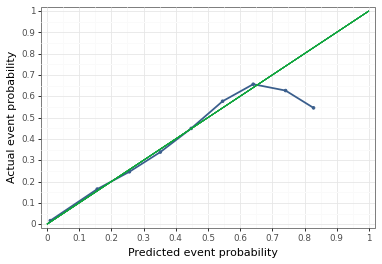

<ggplot: (8787536694390)>

In [39]:
create_calibration_plot(
    data_holdout,
    file_name="ch17-figure-1-logit-m5-calibration",
    prob_var="best_logit_pred_proba",
    actual_var="fast_growth",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)

***b) Confusion table with different thresholds***

The threshold 0.5 is used to convert probabilities to binary classes

In [40]:
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (low growth): ", counts[0])
print(values[1], " (fast grwoth): ", counts[1])

0.0  (low growth):  18321
1.0  (fast grwoth):  4210


Confusion matrix: summarize different type of errors and successfully predicted cases

positive = "yes": explicitly specify the positive case

In [41]:
cm_object1 = confusion_matrix(
    data_holdout["fast_growth"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actul low growth", "Actual fast growth"],
    columns=["Predicted low growth", "Predicted fast growth"],
)
cm1

,Predicted low growth,Predicted fast growth
Actul low growth,13572,1680
Actual fast growth,4749,2530


In [42]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actul low growth", "Actual fast growth"],
    columns=["Predicted low growth", "Predicted fast growth"],
)
cm1b

,Predicted low growth,Predicted fast growth
Actul low growth,13572,1680
Actual fast growth,4749,2530


A sensible choice: mean of predicted probabilities

In [43]:
mean_predicted_default_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_default_prob, 3)

0.323

In [44]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_default_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul low growth", "Actual fast growth"],
    columns=["Predicted low growth", "Predicted fast growth"],
)
cm2

,Predicted low growth,Predicted fast growth
Actul low growth,8560,6692
Actual fast growth,1360,5919


***c) Visualize ROC (with thresholds in steps) on holdout***

What if we want to compare multiple thresholds?

First, discrete ROC (with thresholds in steps) on holdout

In [45]:
thresholds = np.arange(0.05, 0.76, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["fast_growth"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [46]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

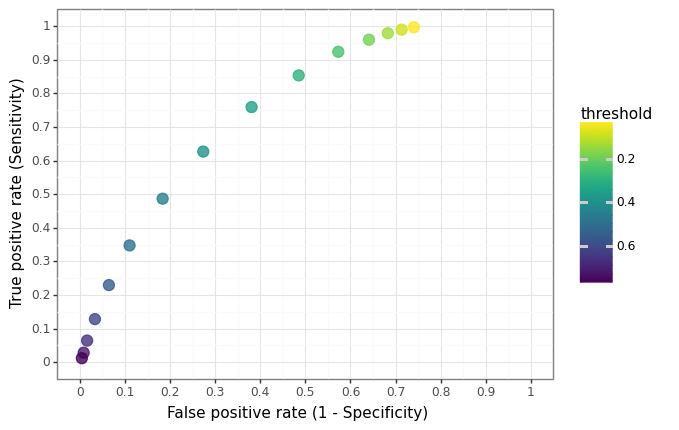

<ggplot: (8787704797175)>

In [47]:
(
    ggplot(
        tpr_fpr_for_thresholds,
        aes(x="false_positive_rates", y="true_positive_rates", color="thresholds"),
    )
    + labs(
        x="False positive rate (1 - Specificity)", y="True positive rate (Sensitivity)"
    )
    + geom_point(size=4, alpha=0.8)
    + scale_color_continuous(trans="reverse", name="threshold")
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + theme_bw()
    + theme(legend_position="right")
)

Continuous ROC on holdout with best model

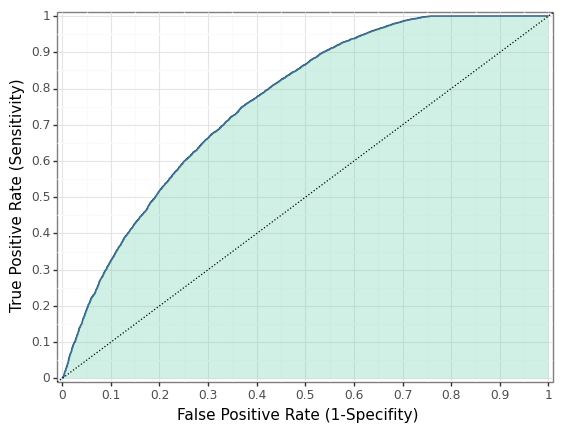

<ggplot: (8787536765648)>

In [48]:
create_roc_plot(data_holdout["fast_growth"], data_holdout["best_logit_pred_proba"])

### 5. Loss Function

Introduce loss function

Relative cost of of a false negative classification (as compared with a false positive classification)

In [49]:
FP = 1
FN = 2
cost = FN / FP

The prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))

In [50]:
prevelance = y_train.sum() / len(y_train)

Draw ROC Curve and find optimal threshold with loss function 

The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

Iterate through:
 1. models
 2. Folds

In [51]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("fast_growth ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["fast_growth"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [52]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()

In [53]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.326543,0.324455,0.544156,0.546605
1,M2,0.314419,0.311073,0.541238,0.539004
2,M3,0.347091,0.344932,0.412225,0.412284
3,M4,0.354668,0.347717,0.418073,0.419663
4,M5,0.350670,0.360313,0.411582,0.409399
5,LASSO,0.347188,0.333066,0.406056,0.404350


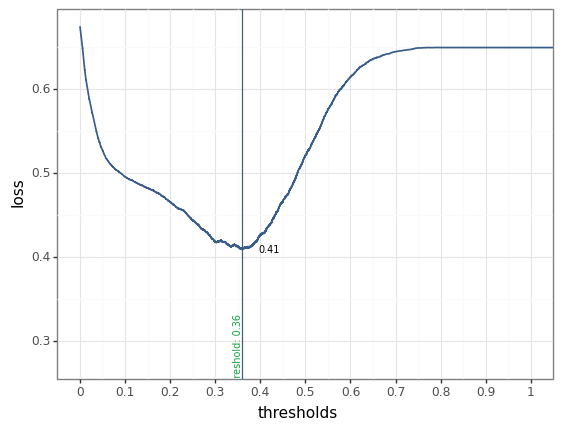

<ggplot: (8787671581784)>

In [54]:
model_to_plot = "M5"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

Create loss plot based on Fold5 in CV

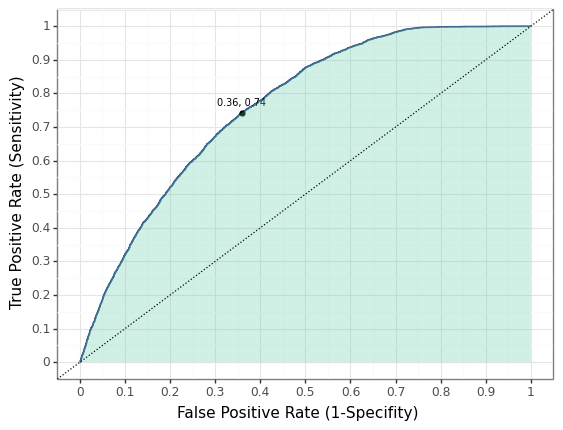

<ggplot: (8787704795498)>

In [55]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)

Let's see our chosen model, M5's holdout expected loss

In [56]:
best_logit_optimal_treshold = best_thresholds_cv["M5"]

# Get expected loss on holdout
holdout_treshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["fast_growth"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["fast_growth"])
round(expected_loss_holdout, 3)

0.413

CM on holdout

In [57]:
cm_object3 = confusion_matrix(data_holdout["fast_growth"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actul low growth", "Actual fast growth"],
    columns=["Predicted low growth", "Predicted fast growth"],
)
cm3

,Predicted low growth,Predicted fast growth
Actul low growth,9467,5785
Actual fast growth,1761,5518


## Predictions with Random Forest

In [58]:
y_train, rfvars_train = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_holdout)

### Graph example for decision tree

<Figure size 640x480 with 0 Axes>

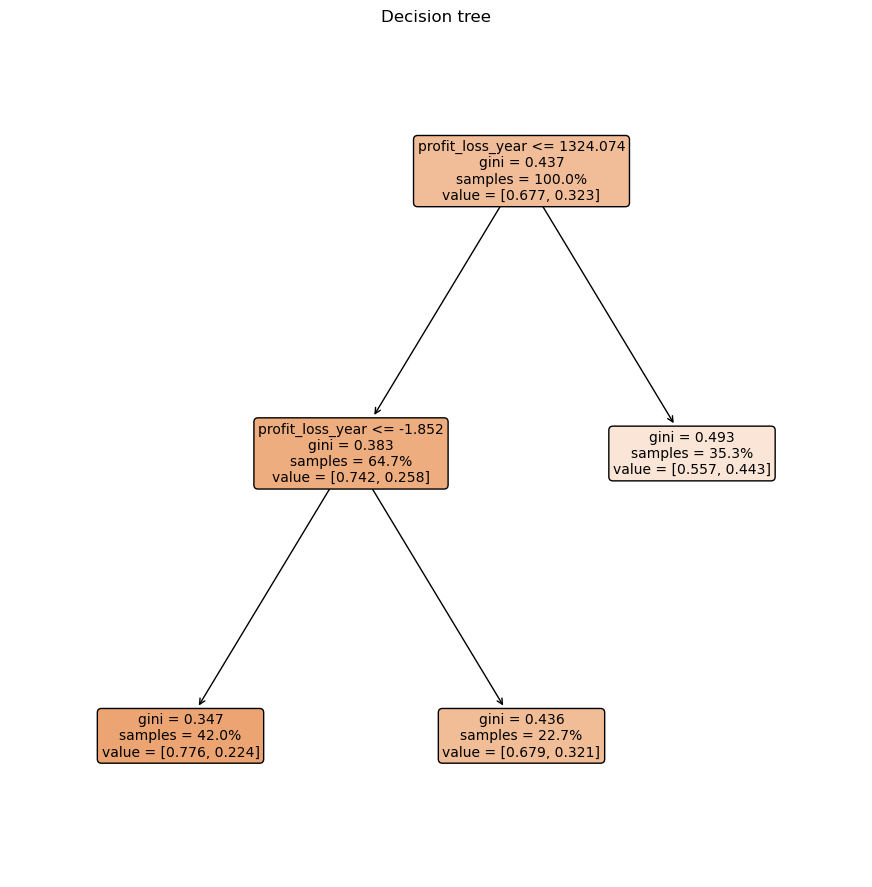

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

data_for_graph = data_train[["profit_loss_year", "foreign_management", "curr_assets"]]
rf_for_graph = DecisionTreeClassifier(
    ccp_alpha=0.0028, min_samples_leaf=100, max_depth=3, random_state=41
).fit(data_for_graph, y_train)

plt.figure()
plt.figure(figsize=(11, 11))
plot_tree(
    rf_for_graph,
    feature_names=data_for_graph.columns,
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
)
plt.title("Decision tree")
plt.show()



### Probability forest

Split by gini, ratio of 1's in each tree, average over trees

In [60]:
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

5 fold cross validation

In [61]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [62]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

Create CV summary table

In [63]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.759313,0.423128
1,5,16,0.759925,0.422956
2,6,11,0.759221,0.422944
3,6,16,0.759503,0.422886
4,7,11,0.759352,0.422811
5,7,16,0.759512,0.422768


Obtain optimal parameter values

In [64]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 5, 'min_samples_split': 16}

Get average (ie over the folds) RMSE and AUC

In [65]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [66]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,9.0,0.460674,0.613843
M2,16.0,0.459420,0.621715
M3,39.0,0.425950,0.756894
M4,83.0,0.427940,0.752939
M5,142.0,0.424820,0.759597
LASSO,124.0,0.423188,0.764132
RF,n.a.,0.422956,0.759925


Extract fold level RMSE and AUC

In [67]:
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

In [68]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.461470,0.460013,0.428654,0.428550,0.426438,0.424751,0.424511
1,0.460920,0.459791,0.425748,0.430150,0.425970,0.423301,0.423488
2,0.460404,0.459428,0.425690,0.425333,0.424104,0.423299,0.421458
3,0.458947,0.457780,0.423631,0.425801,0.422958,0.421435,0.421074
4,0.461629,0.460089,0.426028,0.429865,0.424632,0.423152,0.423300


In [69]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.613108,0.622561,0.749787,0.751323,0.755098,0.759533,0.754790
1,0.608639,0.615537,0.756278,0.744721,0.755567,0.763282,0.755233
2,0.616205,0.621698,0.757925,0.759755,0.761568,0.764309,0.765356
3,0.621129,0.627135,0.763061,0.758284,0.764106,0.767640,0.764526
4,0.610134,0.621644,0.757416,0.750611,0.761646,0.765896,0.759719


Now use loss function and search for best thresholds and expected loss over folds 

In [70]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["fast_growth"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["fast_growth"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)



In [71]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)

In [72]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.423,0.76,0.363,0.364,0.419,0.416


Create plots based on Fold5 in CV 

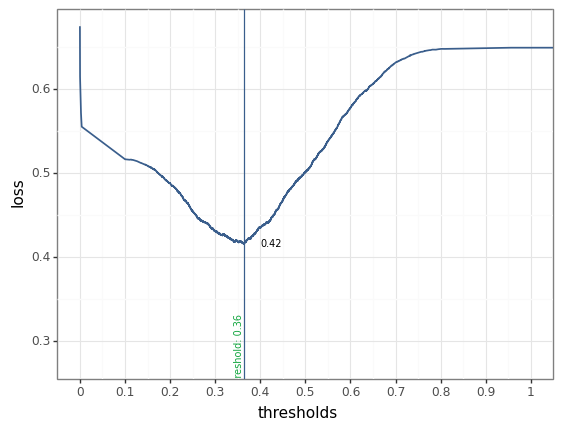

<ggplot: (8787537545343)>

In [73]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

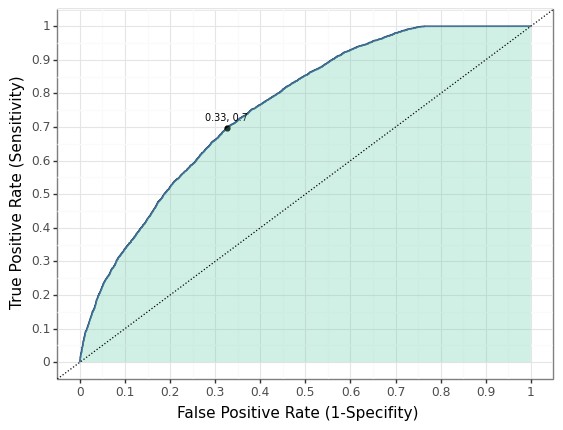

<ggplot: (8787460045282)>

In [74]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

Take model to holdout and estimate RMSE, AUC and expected loss 

In [75]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.423

ROC AUC  on holdout

In [76]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.76

 Get expected loss on holdout

In [77]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)

0.421